In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random

from collections import defaultdict
from torchvision.models import resnet18
from torchvision.models.resnet import ResNet18_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image
from sklearn.model_selection import train_test_split

from src.utils import load_active_learning_embeddings
from src.training.engine import create_resnet18_model, calculate_metrics, epoch_forward_pass

In [2]:
torch.manual_seed(2004)
random.seed(2004)
np.random.seed(2004)

In [3]:
BATCH_SIZE = 4
LR = 0.025 # Same as paper
MOMENTUM = 0.9 # Same as paper
USE_NESTEROV = True # Same as paper
EPOCHS = 100
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PRINT_INTERVAL = 1000

MODEL_SAVE_DIR = "models"
CLASSES = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [4]:
# Load active learning embeddings and build dataset
version = "typiclust"
setting = "top"


directories = os.listdir(f"embeddings/{version}/{setting}")

embeddings_dir = f"embeddings/{version}/{setting}/{directories[0]}"

all_images, all_labels, _ = load_active_learning_embeddings(embeddings_dir)

Embeddings shape: 10
1 255
(32, 32, 3) ()
8 232
(32, 32, 3) ()
15 251
(32, 32, 3) ()
4 235
(32, 32, 3) ()
9 225
(32, 32, 3) ()
18 252
(32, 32, 3) ()
3 255
(32, 32, 3) ()
5 255
(32, 32, 3) ()
31 213
(32, 32, 3) ()
53 255
(32, 32, 3) ()


In [5]:
# Separate into train and validation sets:
train_images, val_images, train_labels, val_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=2004)

print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")

Number of training images: 8
Number of validation images: 2


In [6]:
def count_instances_per_class(labels):
    class_counts = defaultdict(int)
    for label in labels:
        class_counts[CLASSES[label.item()]] += 1
    for c_class in CLASSES:
        if c_class not in class_counts:
            class_counts[c_class] = 0
    return dict(class_counts)

def print_class_counts(class_counts, labels):
    for c_class, count in class_counts.items():
        print(f"Class: {c_class} | Count: {count} | Percentage: {count / len(labels) * 100:.5f}%")

In [7]:
train_class_counts = count_instances_per_class(train_labels)
val_class_counts = count_instances_per_class(val_labels)

print("Training class counts:")
print_class_counts(train_class_counts, train_labels)
print("\n")

print("Validation class counts:")
print_class_counts(val_class_counts, val_labels)

Training class counts:
Class: dog | Count: 4 | Percentage: 50.00000%
Class: ship | Count: 1 | Percentage: 12.50000%
Class: bird | Count: 1 | Percentage: 12.50000%
Class: horse | Count: 2 | Percentage: 25.00000%
Class: plane | Count: 0 | Percentage: 0.00000%
Class: car | Count: 0 | Percentage: 0.00000%
Class: cat | Count: 0 | Percentage: 0.00000%
Class: deer | Count: 0 | Percentage: 0.00000%
Class: frog | Count: 0 | Percentage: 0.00000%
Class: truck | Count: 0 | Percentage: 0.00000%


Validation class counts:
Class: ship | Count: 2 | Percentage: 100.00000%
Class: plane | Count: 0 | Percentage: 0.00000%
Class: car | Count: 0 | Percentage: 0.00000%
Class: bird | Count: 0 | Percentage: 0.00000%
Class: cat | Count: 0 | Percentage: 0.00000%
Class: deer | Count: 0 | Percentage: 0.00000%
Class: dog | Count: 0 | Percentage: 0.00000%
Class: frog | Count: 0 | Percentage: 0.00000%
Class: horse | Count: 0 | Percentage: 0.00000%
Class: truck | Count: 0 | Percentage: 0.00000%


In [8]:
transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=0), # Padding not mentioned in paper
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(label)
        return image, label
    
# train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_set = CustomDataset(images=train_images, labels=train_labels, transform=transform)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_set = CustomDataset(images=val_images, labels=val_labels, transform=transform)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
print(len(train_dl))
print(len(test_dl))

2
2500


In [11]:
data = train_dl.__iter__().__next__()
images, labels = data
print(images.shape, labels.shape)

torch.Size([4, 3, 32, 32]) torch.Size([4])


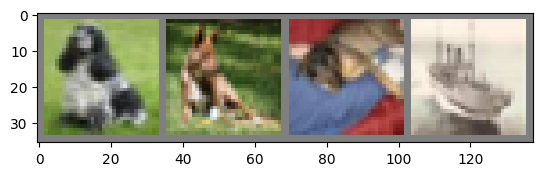

dog   dog   dog   ship 


In [12]:
def imshow(img):
    img = img / 2 + 0.5 # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

data_iter = iter(train_dl)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{CLASSES[labels[j]]:5s}" for j in range(BATCH_SIZE)))

In [13]:
def create_resnet18_model():
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(512, 10) # Adapt final layer to CIFAR-10 classes
    return model

In [14]:
model = create_resnet18_model()
model = model.to(DEVICE)

In [15]:
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, nesterov=USE_NESTEROV)
scheduler = CosineAnnealingLR(optimiser, T_max=EPOCHS) # T_max is the number of epochs

In [16]:
print(len(train_dl), len(test_dl))

2 2500


In [17]:
num_train_batches = len(train_dl)

In [18]:
for epoch in range(EPOCHS):
    model.train()
    train_loss, train_precision, train_recall, train_f1_score, train_accuracy = epoch_forward_pass(
                                                                                    model=model,
                                                                                    criterion=criterion,
                                                                                    optimiser=optimiser,
                                                                                    data_loader=train_dl,
                                                                                    epoch=epoch,
                                                                                    num_batches=len(train_dl),
                                                                                    classes=CLASSES,
                                                                                    device=DEVICE,
                                                                                    print_interval=PRINT_INTERVAL,
                                                                                    mode="train"
                                                                                    )
    # Print metrics for each class:
    print(f"Epoch: {epoch + 1}")
    print(f"Training metrics")
    print(f"Average train loss: {train_loss:.4f}")
    for class_name in CLASSES:
        print(f"Class: {class_name} | Precision: {train_precision[class_name]:.2f} | Recall: {train_recall[class_name]:.2f} | F1 Score: {train_f1_score[class_name]:.2f} | Accuracy: {train_accuracy[class_name]:.2f}")
    
    # Validate model after each epoch
    model.eval()
    with torch.no_grad():
        val_loss, val_precision, val_recall, val_f1_score, val_accuracy = epoch_forward_pass(
                                                                                            model=model,
                                                                                            criterion=criterion,
                                                                                            optimiser=optimiser,
                                                                                            data_loader=val_dl,
                                                                                            epoch=epoch,
                                                                                            num_batches=len(val_dl),
                                                                                            classes=CLASSES,
                                                                                            device=DEVICE,
                                                                                            print_interval=PRINT_INTERVAL,
                                                                                            mode="val"
                                                                                            )
    # Print metrics for each class:
    print(f"Validation metrics")
    print(f"Average val loss: {val_loss:.4f}")
    for class_name in CLASSES:
        print(f"Class: {class_name} | Precision: {val_precision[class_name]:.2f} | Recall: {val_recall[class_name]:.2f} | F1 Score: {val_f1_score[class_name]:.2f} | Accuracy: {val_accuracy[class_name]:.2f}")
    print("\n")

    # Update scheduler after each epoch
    scheduler.step()

Epoch: 1 |  Batch: 2/2 | Loss: 0.5925702750682831 | LR: 0.025
Epoch: 1
Training metrics
Average train loss: 0.5926
Class: plane | Precision: 0.00 | Recall: 0.00 | F1 Score: 0.00 | Accuracy: 0.00
Class: car | Precision: 0.00 | Recall: 0.00 | F1 Score: 0.00 | Accuracy: 0.00
Class: bird | Precision: 0.00 | Recall: 0.00 | F1 Score: 0.00 | Accuracy: 0.00
Class: cat | Precision: 0.00 | Recall: 0.00 | F1 Score: 0.00 | Accuracy: 0.00
Class: deer | Precision: 0.00 | Recall: 0.00 | F1 Score: 0.00 | Accuracy: 0.00
Class: dog | Precision: 0.50 | Recall: 0.50 | F1 Score: 0.50 | Accuracy: 50.00
Class: frog | Precision: 0.00 | Recall: 0.00 | F1 Score: 0.00 | Accuracy: 0.00
Class: horse | Precision: 0.00 | Recall: 0.00 | F1 Score: 0.00 | Accuracy: 0.00
Class: ship | Precision: 0.00 | Recall: 0.00 | F1 Score: 0.00 | Accuracy: 0.00
Class: truck | Precision: 0.00 | Recall: 0.00 | F1 Score: 0.00 | Accuracy: 0.00
Epoch: 1 |  Batch: 1/1 | Loss: 4.404018402099609 | LR: 0.025
Validation metrics
Average val lo

In [19]:
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
model_path = f"{MODEL_SAVE_DIR}/fully_supervised_model.pth"
torch.save(model.state_dict(), model_path)

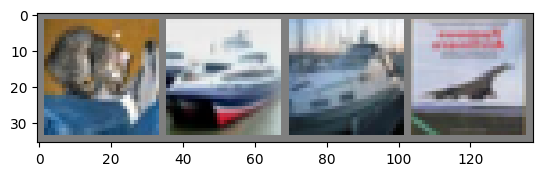

Ground truth: cat  , ship , ship , plane


In [20]:
data_iter = iter(test_dl)
images, labels = next(data_iter)
imshow(torchvision.utils.make_grid(images))
print(f"Ground truth: {', '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE))}")

In [21]:
saved_model = create_resnet18_model()
saved_model.load_state_dict(torch.load(model_path))
saved_model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
output = saved_model(images.to(DEVICE))
_, predicted = torch.max(output, 1)

In [23]:
print(f"Predictions: {', '.join(f'{CLASSES[predicted[j]]:5s}' for j in range(BATCH_SIZE))}")

Predictions: bird , horse, dog  , dog  


In [24]:
total = {class_name: 0 for class_name in CLASSES}
true_positive = defaultdict(int)
false_positive = defaultdict(int)
false_negative = defaultdict(int)

saved_model.eval()

with torch.no_grad():
    for data in test_dl:
        images, labels = data

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        output = saved_model(images)

        _, predicted = torch.max(output, 1)
        
        for label, prediction in zip(labels, predicted):
            total[CLASSES[label]] += 1 # Track total for accuracy

            if label == prediction:
                true_positive[CLASSES[label]] += 1
            else:
                false_positive[CLASSES[prediction]] += 1 # Predicted class is wrong
                false_negative[CLASSES[label]] += 1 # Actual class is wrong

In [25]:
precision, recall, f1_score, accuracy = calculate_metrics(
                                                        true_positive=true_positive, 
                                                        false_positive=false_positive, 
                                                        false_negative=false_negative, 
                                                        total=total,
                                                        classes=CLASSES
                                                        )
total_accuracy = sum(true_positive.values()) / sum(total.values())

In [26]:
for class_name in total.keys():
    print(f"Class name: {class_name}")
    print(f"Accuracy: {accuracy[class_name]:.4f}")
    print(f"Precision: {precision[class_name]:.4f}")
    print(f"Recall: {recall[class_name]:.4f}")
    print(f"F1 Score: {f1_score[class_name]:.4f}")
    print("\n")
print(f"Total accuracy: {total_accuracy:.4f}")

Class name: plane
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


Class name: car
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


Class name: bird
Accuracy: 6.3000
Precision: 0.1403
Recall: 0.0630
F1 Score: 0.0870


Class name: cat
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


Class name: deer
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


Class name: dog
Accuracy: 72.2000
Precision: 0.1229
Recall: 0.7220
F1 Score: 0.2100


Class name: frog
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


Class name: horse
Accuracy: 29.9000
Precision: 0.1191
Recall: 0.2990
F1 Score: 0.1704


Class name: ship
Accuracy: 26.9000
Precision: 0.2307
Recall: 0.2690
F1 Score: 0.2484


Class name: truck
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


Total accuracy: 0.1353
